# Normalization
There are several popular methods for normalizing data and infinitely many fine-tuned techniques for special cases. Here we will explore the following strategies:
* Probability Density (PDF)
* Scaling to A Range
* Log Scaling
* Z-Score
* Re-Classifying to $dPrice$

The first two will involve modifying range of stock prices. Within the last we will modify our comparison entirely; instead of comparing stock prices we will only compare _changes_ in price.

This notebook will be setup to search for the closest period Q to a randomly selected period P using each strategy.

Text(0, 0.5, 'Day Close (USD)')

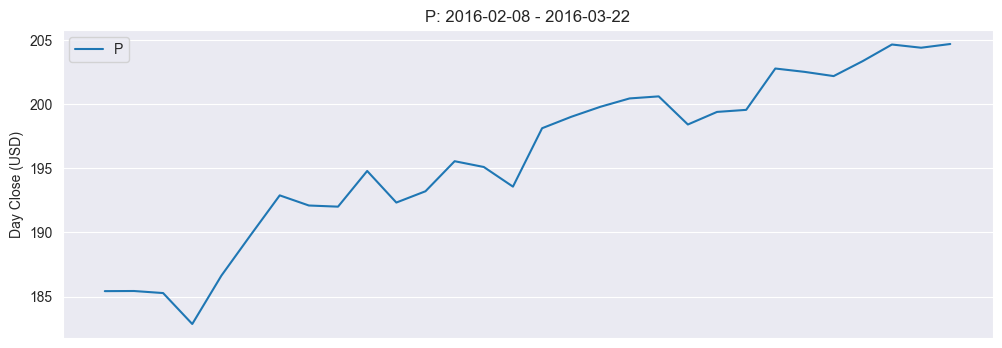

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
# I have no idea what I'm doing:
pd.options.mode.chained_assignment = None

# The constants we will be working with:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0)) * 100_000

spy = pd.read_csv('../data/SPY.csv', parse_dates=True)

p_duration= 30
p_start = random.randint(0, len(spy) - p_duration)

# Get our random period and other periods.
p = spy.iloc[p_start : p_start + p_duration]
q_rangeA = [spy.iloc[i:i+p_duration] for i in range(0, p_start-p_duration, p_duration)]
q_rangeB = [spy.iloc[p_start + p_duration : i + p_start + p_duration] for i in range(p_start + p_duration, len(spy), p_duration)]

# Ensure we don't have any straggler ranges.
all_q = [q for q in q_rangeA + q_rangeB if len(q) == p_duration]

plt.figure(figsize=(12, 4))
plt.title(f'P: {spy.iloc[p_start]["Date"]} - {spy.iloc[p_start + p_duration]["Date"]}')
sns.lineplot(data=p, x="Date", y='Close', label='P')
plt.xticks([])
plt.xlabel('')
plt.ylabel('Day Close (USD)')

In [2]:
# Normalization Techniques
def normalize_pdf(data):
    return data / data.sum()

def normalize_range_scale(data):
    return (data - (data.min()) + 0.001) / (data.max() - data.min())

# don't have the gumption to figure out how 0's are still getting into my log.... :(
def normalize_log(data):
    return np.log(np.abs(data) + 0.001)

def normalize_zscore(data):
    return (data - np.mean(data)) / np.std(data)

def normalize_dprice(data):
    return data.pct_change(-1)

In [3]:
# Normalize and Prepare Data
p.reset_index(inplace=True)
p['NormClose'] = normalize_pdf(p['Close'])
p['NormRange'] = normalize_range_scale(p['Close'])
p['NormLog'] = normalize_log(p['Close'])
p['NormZScore'] = normalize_zscore(p['Close'])
p['NormDPrice'] = normalize_dprice(p['Close'])

for period in all_q:
    period.reset_index(inplace=True)
    period['NormClose'] = normalize_pdf(period['Close'])
    period['NormRange'] = normalize_range_scale(period['Close'])
    period['NormLog'] = normalize_log(period['Close'])
    period['NormZScore'] = normalize_zscore(period['Close'])
    period['NormDPrice'] = normalize_dprice(period['Close'])

/Users/peterv/PycharmProjects/DejaVu/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 1200x400 with 0 Axes>

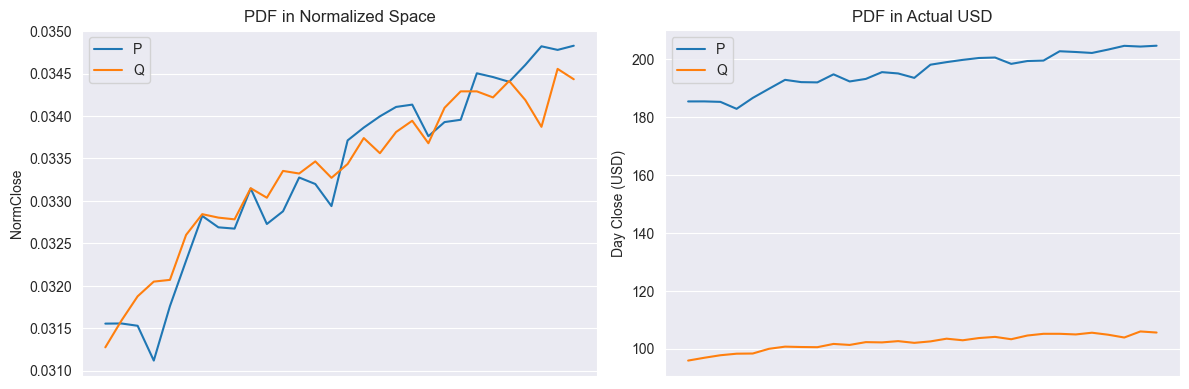

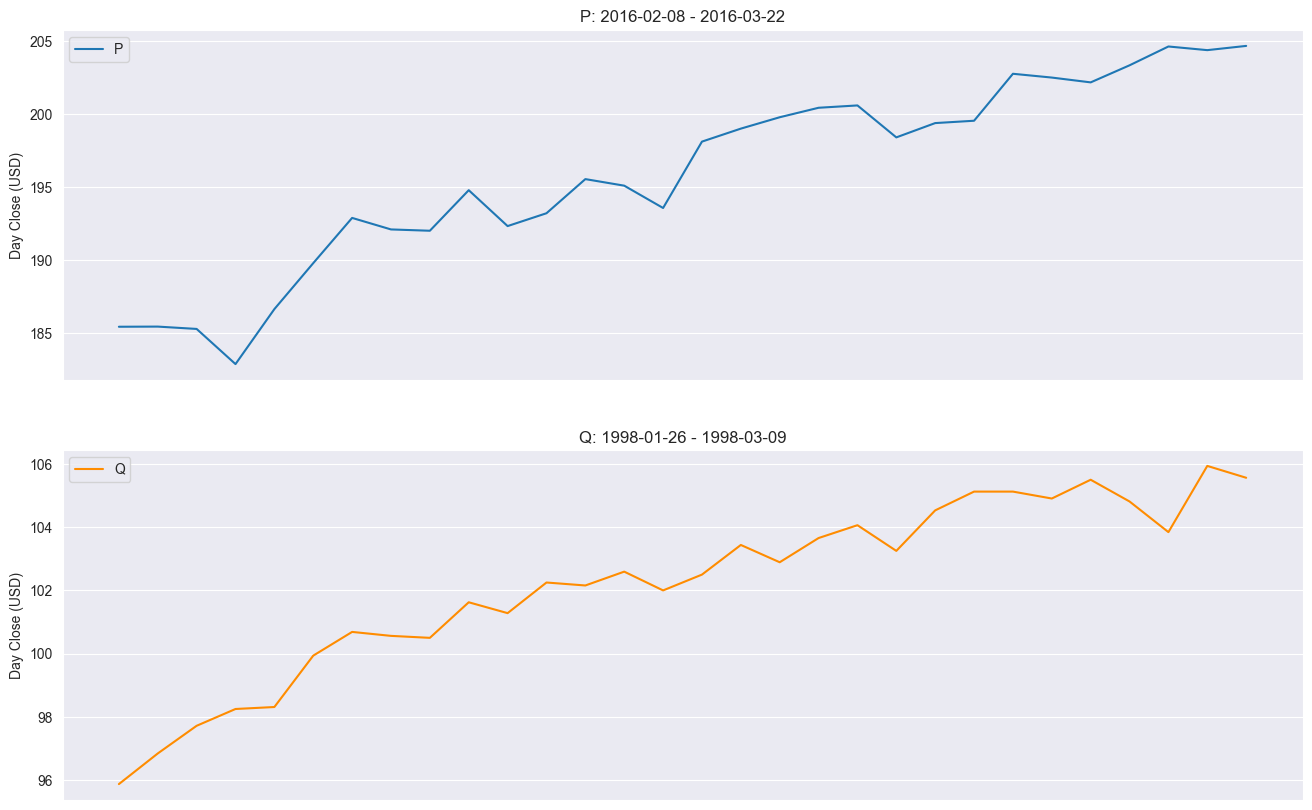

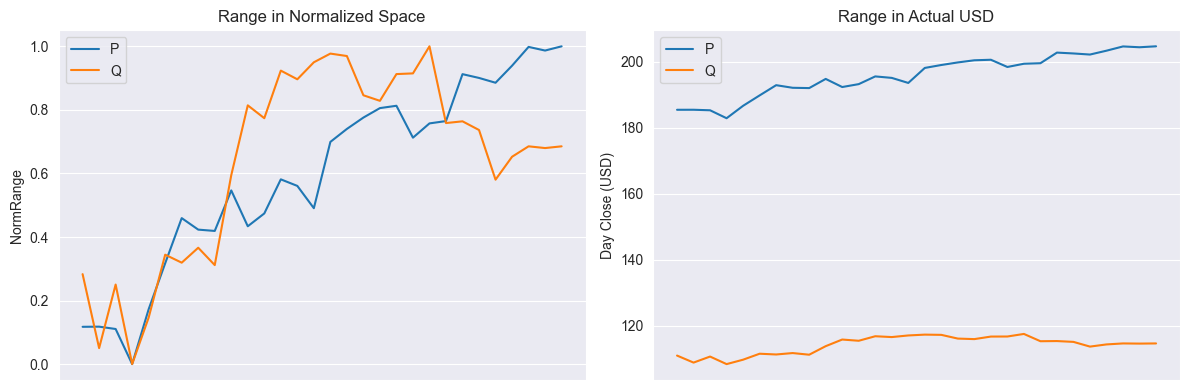

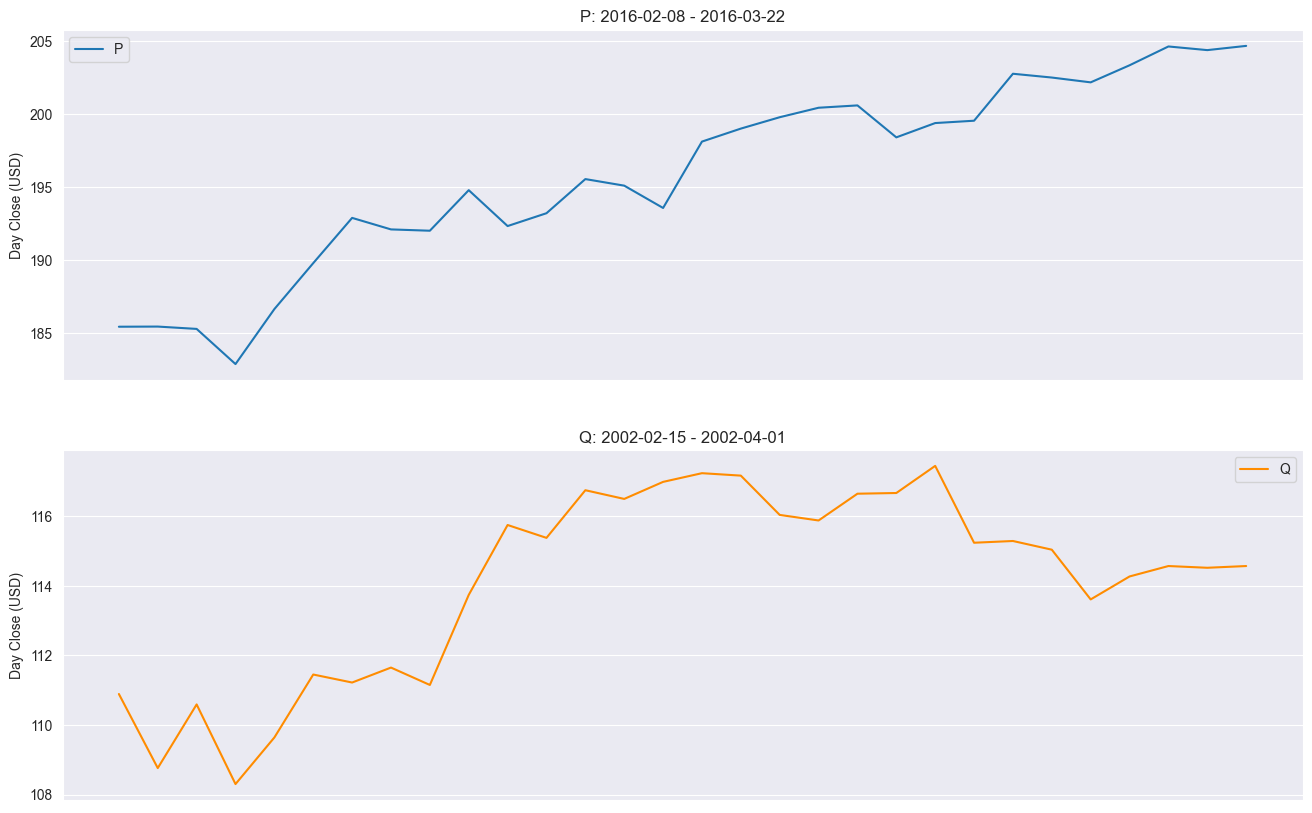

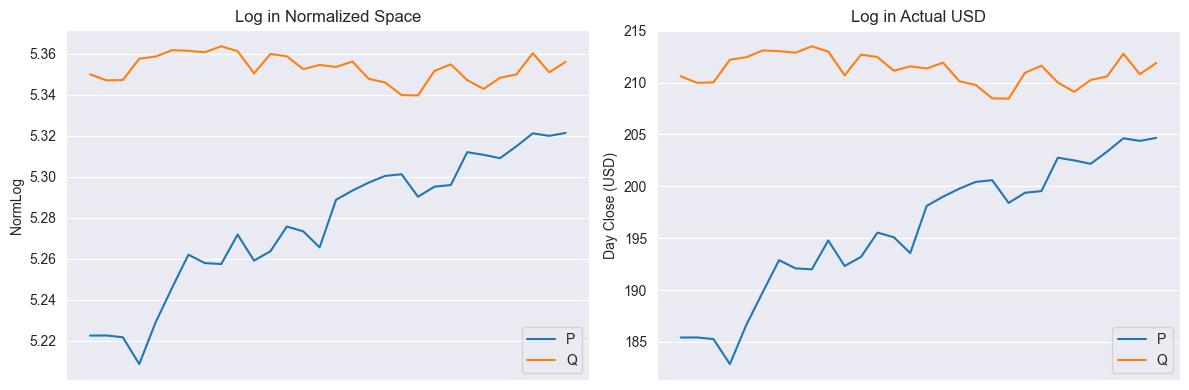

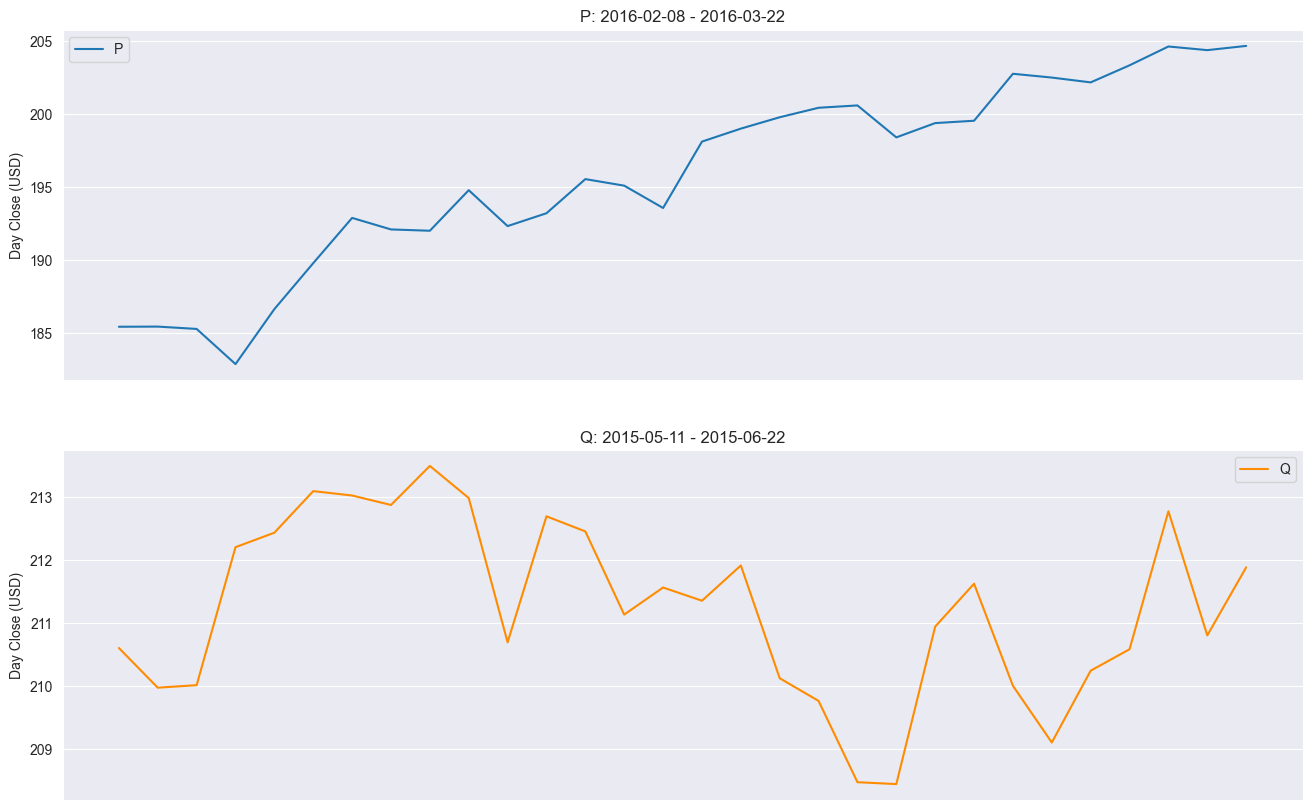

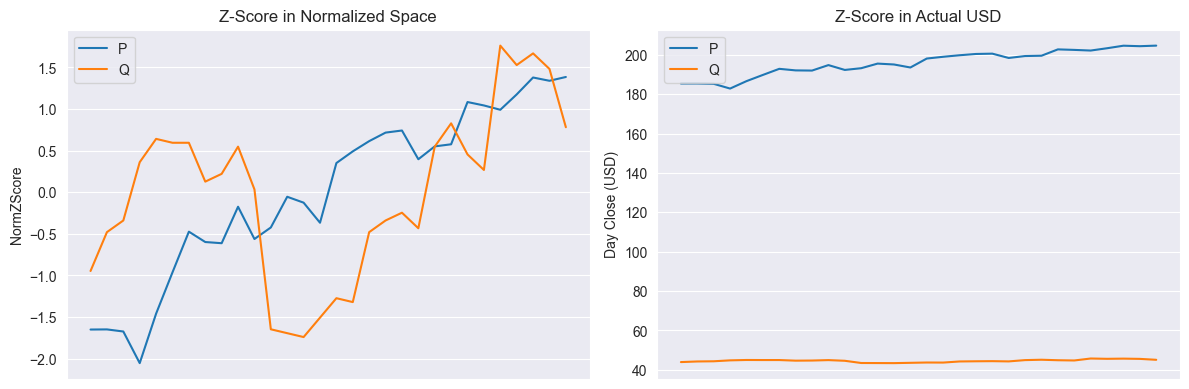

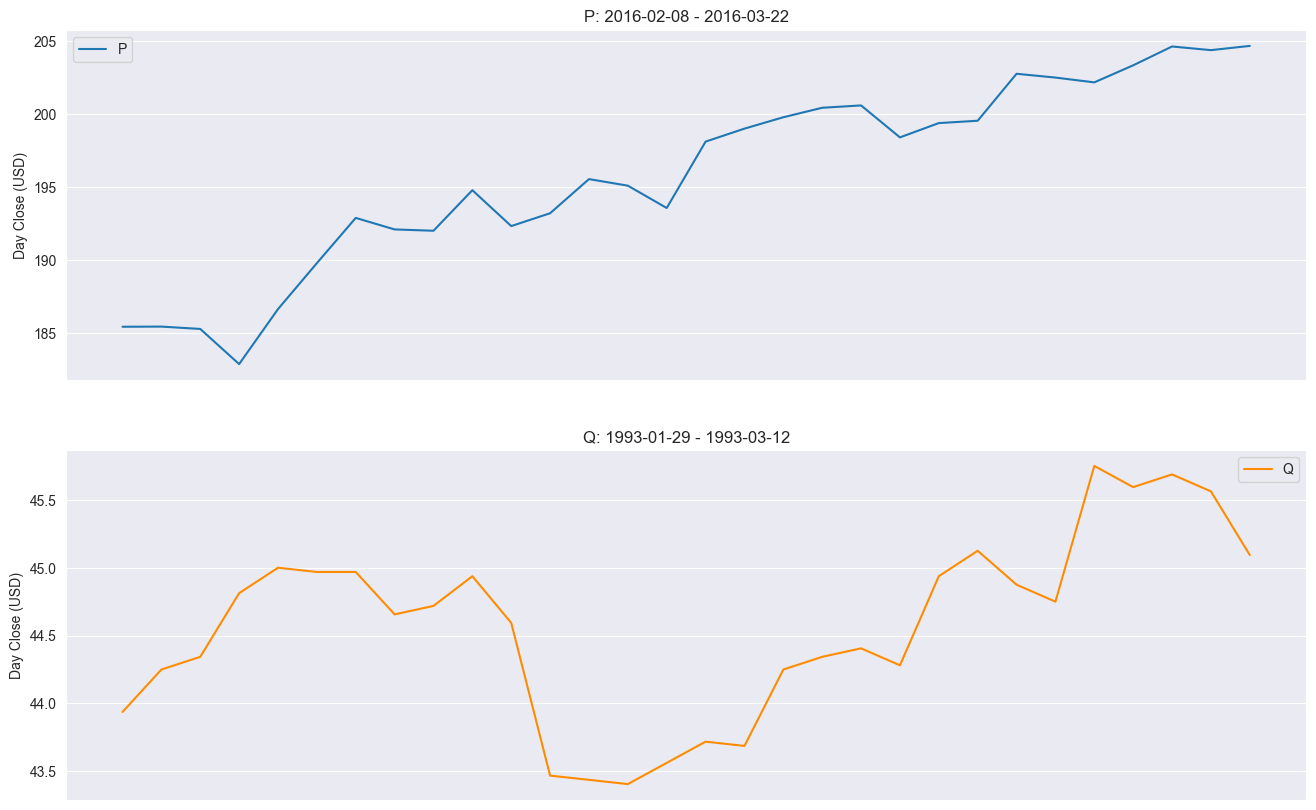

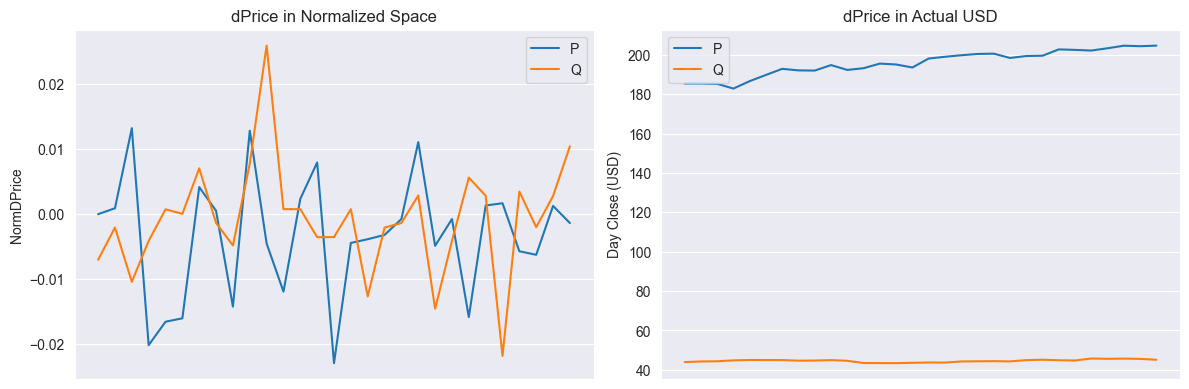

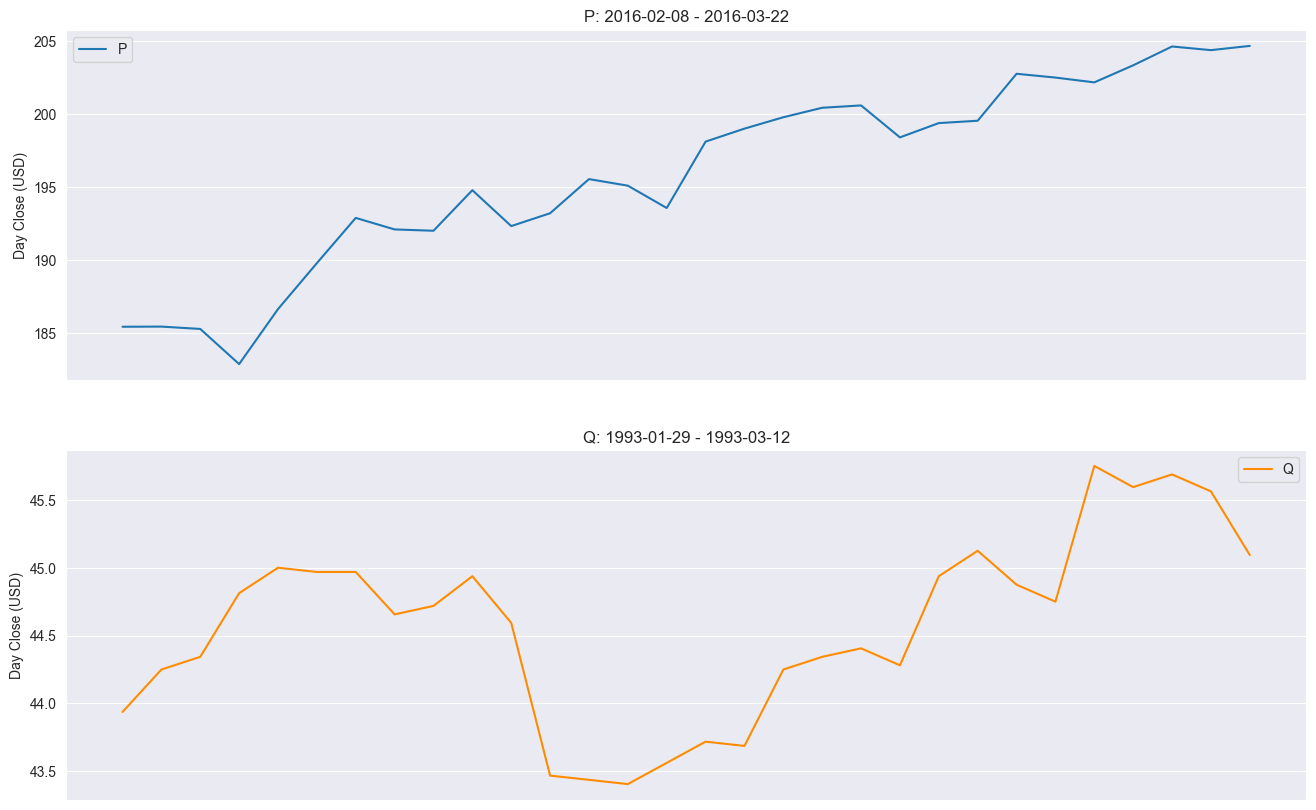

In [4]:
# Fetch the best matches in each category.
best_matches = {
    'PDF': min(all_q, key=lambda q: kl_divergence(p['NormClose'], q['NormClose'])),
    'Range': min(all_q, key=lambda q: kl_divergence(p['NormRange'], q['NormRange'])),
    'Log': min(all_q, key=lambda q: kl_divergence(p['NormLog'], q['NormLog'])),
    'Z-Score': min(all_q, key=lambda q: kl_divergence(p['NormZScore'], q['NormZScore'])),
    'dPrice': min(all_q, key=lambda q: kl_divergence(p['NormDPrice'], q['NormDPrice'])),
}
strats = ['NormClose', 'NormRange', 'NormLog', 'NormZScore', 'NormDPrice']

# Plot the best matches.
plt.figure(figsize=(12, 4))
for (key, value), strat in zip(best_matches.items(), strats):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title(f'{key} in Normalized Space')
    sns.lineplot(data=p, x=p.index, y=f'{strat}', label='P')
    sns.lineplot(data=value, x=value.index, y=f'{strat}', label='Q')
    plt.xticks([])
    plt.xlabel('')
    plt.ylabel(f'{strat}')
    plt.subplot(1, 2, 2)
    plt.title(f'{key} in Actual USD')
    sns.lineplot(data=p, x=p.index, y='Close', label='P')
    sns.lineplot(data=value, x=value.index, y='Close', label='Q')
    plt.xticks([])
    plt.xlabel('')
    plt.ylabel('Day Close (USD)')
    plt.tight_layout()
    plt.show()
    # Each in their own scale
    plt.figure(figsize=(16, 10))
    plt.subplot(2, 1, 1)
    plt.title(f'P: {spy.iloc[p_start]["Date"]} - {spy.iloc[p_start + p_duration]["Date"]}')
    sns.lineplot(data=p, x="Date", y='Close', label='P')
    plt.xticks([])
    plt.xlabel('')
    plt.ylabel('Day Close (USD)')
    plt.subplot(2, 1, 2)
    plt.title(f"Q: {value.iloc[0]['Date']} - {value.iloc[-1]['Date']}")
    sns.lineplot(data=value, x="Date", y='Close', label='Q', color='darkorange')
    plt.xticks([])
    plt.xlabel('')
    plt.ylabel('Day Close (USD)')


# Observations
You have probably not run this notebook as many times as I have. Going _purely_ based on my own eyes and their ability (or lack thereof) it is clear that _all_ the selected normalization strategies appear to work. At least they work sometimes... and other times they do not. It is not entirely clear to me which conditions are breaking X strategy's reliability, and there appears to be a bug where invalid inputs are sneaking into my log, and I am aware that some of these inputs for KL-D are not proper distributions but alas, I still have quite a bit of work cut out for me ahead so we must move on.

One thing I noticed is that it would be nice to look at all the graph shapes at once, and also come up with a more objective way to compare our strategies. I will do that in the next section.

P Range........ 2016-02-08 - 2016-03-22

                  Selected Q Range    
PDF............ 1998-01-26 - 1998-03-09
Range.......... 2002-02-15 - 2002-04-01
Log............ 2015-05-11 - 2015-06-22
Z-Score........ 1993-01-29 - 1993-03-12
dPrice......... 1993-01-29 - 1993-03-12


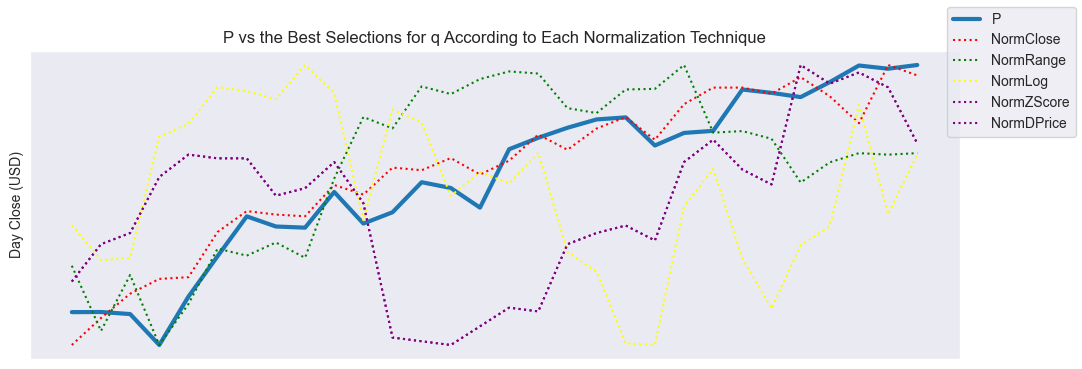

In [5]:
# Gather up unique selections
p_string = f'{"P Range":.<15} {spy.iloc[p_start]["Date"]} - {spy.iloc[p_start + p_duration]["Date"]}\n'
print(p_string)
print(f'{" ": <15}{"Selected Q Range":^23}')
for (key, value) in best_matches.items():
    print(f'{key:.<15} {value.iloc[0]["Date"]:} - {value.iloc[-1]["Date"]}')


fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.set_title(f'P vs the Best Selections for q According to Each Normalization Technique')
ax1.set_ylabel('Day Close (USD)')
ax1.plot(p['Close'], label='P', linewidth=3)
ax1.set_xlabel('')
ax1.set_xticks([])
ax1.set_yticks([])

selected_dates = set()
colors = ['red', 'green', 'yellow', 'purple', 'orange']
i = -1
for (key, value), strat in zip(best_matches.items(), strats):
    ax2 = ax1.twinx()
    if value.iloc[0]['Date'] not in selected_dates:
        selected_dates.add(value.iloc[0]['Date'])
        i += 1
    ax2.plot(value['Close'], label=f'{strat}', color=f'{colors[i]}', ls='dotted')
    ax2.set_xlabel('')
    ax2.set_xticks([])
    ax2.set_yticks([])
fig.legend()

<bound method NDFrame.head of    PDF  Range  Log  Z-Score  dPrice
0    3      3    3       29      29
1   12     15    5       29      29
2   29     26    5       29      29
3   25     13    4       29      29
4   23     24   17       29      29
5    9     14    2       29      29
6   13     27   28       29      29
7   31     15    6       29      29
8   30     20   18       29      29
9   17      5   24       29      29>
PDF        int64
Range      int64
Log        int64
Z-Score    int64
dPrice     int64
dtype: object


<Axes: >

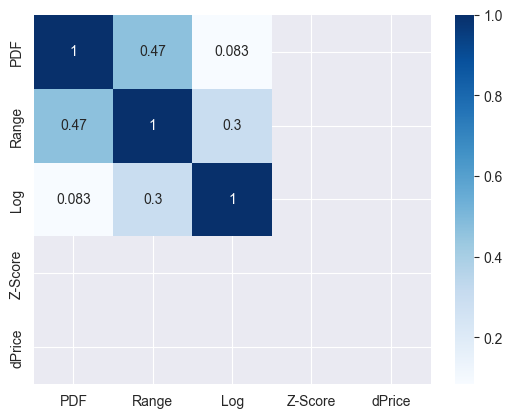

In [6]:
from correlatingNormalization import sample_kl
sample_data = sample_kl(10)
print(sample_data.head)
# TODO: Fix this
print(sample_data.dtypes)
sns.heatmap(sample_data.corr(), annot=True, cmap='Blues')
# sample_data = sample_data.pivot(columns=['PDF', 'Range', 'Log', 'Z-Score', 'dPrice'], index=['PDF', 'Range', 'Log', 'Z-Score', 'dPrice'])
# sns.heatmap(sample_data, annot=True, cmap='Blues')

# Direct Comparison
Now we are able to see, more objectively, that relationships between the normalization techniques as I have defined them (correctly or incorrectly).
As suspected, the PDF and Range are somewhat correlated, Z-Score and dPrice appear to _always_ produce the same results, and the Log seems to always produce its own best fit.

These are interesting findings, though I suppose they do not single out any one technique as being objectively superior to the others. I think that subjectively the PDF is the best as it is the most intuitive and still produces good results, but I am not sure that is the best way to go about it. I will have to think about it some more another day...